In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract pillow
!apt-get install -y tesseract-ocr-jpn


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [85.0 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,902 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,468 kB]


In [ ]:
import pytesseract
from PIL import Image
import json

img = Image.open('/content/スクリーンショット 2026-02-07 173412.png')

data = pytesseract.image_to_data(
    img,
    lang='jpn',
    config='--psm 6',
    output_type=pytesseract.Output.DICT
)


In [ ]:
import cv2, numpy as np, json
from PIL import Image

img_path = "/home/スクリーンショット 2026-01-14 174845.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 1) 二値化（手書きなら適応二値化が無難）
bin_img = cv2.adaptiveThreshold(
    img, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# 2) 小ノイズ除去（点を消しすぎない程度）
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

# 3) 連結成分（文字の塊）を抽出
num, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

elements = []
H, W = bin_img.shape

for i in range(1, num):  # 0は背景
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    # フィルタ（ここは後で調整）
    if area < 8:      # 小さすぎるノイズ除外（点は残したいので低め）
        continue
    if w > 0.9*W or h > 0.9*H:
        continue

    elements.append({
        "id": len(elements),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(cx), float(cy)],
        "area": int(area),
        "text_candidates": []  # ←ここに後で候補を入れる
    })

out = {"image": img_path, "num_elements": len(elements), "elements": elements}
with open("/content/min_units.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

print("最小単位候補数:", len(elements))


最小単位候補数: 360


In [ ]:
import cv2
import numpy as np
import json
from PIL import Image, ImageDraw, ImageFont

# ===== 画像パス =====
img_path = "/home/スクリーンショット 2026-01-14 174845.png"

# ===== 読み込み =====
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ===== 二値化（手書き用）=====
bin_img = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# ===== 小ノイズ除去 =====
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

# ===== 連結成分抽出 =====
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

elements = []

H, W = bin_img.shape

for i in range(1, num_labels):  # 0は背景
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    # ノイズ除去条件（緩め）
    if area < 10:
        continue
    if w < 2 or h < 2:
        continue

    elements.append({
        "id": len(elements),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(cx), float(cy)],
        "area": int(area)
    })

print("最小単位数:", len(elements))

# ===== 可視化 =====
pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(pil_img)

for e in elements:
    x, y, w, h = e["bbox"]
    draw.rectangle(
        [(x, y), (x + w, y + h)],
        outline="red",
        width=2
    )
    draw.text((x, y-10), str(e["id"]), fill="blue")

out_path = "/content/min_units_overlay.png"
pil_img.save(out_path)

# 普通サイズを基準にする
heights = [e["bbox"][3] for e in elements]
avg_height = sum(heights) / len(heights)

sup_candidates = []

for e_small in elements:
    w, h = e_small["bbox"][2], e_small["bbox"][3]

    if w < 10 and h < 10:  # 小さい塊

        sx, sy = e_small["center"]

        for e_big in elements:
            bw, bh = e_big["bbox"][2], e_big["bbox"][3]

            if bw >= 10 and bh >= 10:  # 普通サイズ

                bx, by = e_big["center"]

                # 厳しめ条件
                if (
                    sy < by - 0.35 * bh and          # しっかり上に
                    sx > bx and                     # 右側
                    sx - bx < 0.8 * bw and          # 近い
                    h < 0.8 * bh                    # 小さい
                ):
                    sup_candidates.append((e_small["id"], e_big["id"]))

print("上付き候補数:", len(sup_candidates))
sup_candidates[:10]





最小単位数: 300
上付き候補数: 84


[(1, 130),
 (2, 67),
 (2, 85),
 (2, 108),
 (2, 122),
 (2, 135),
 (3, 86),
 (3, 103),
 (3, 124),
 (3, 146)]

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

# ===== 画像パス =====
img_path = "/bin/スクリーンショット 2026-02-16 214112.png"

# ===== 読み込み =====
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ===== 二値化 =====
bin_img = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# ===== ノイズ軽減 =====
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

# ===== 連結成分抽出 =====
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

elements = []

for i in range(1, num_labels):  # 0は背景
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    if area < 10:
        continue

    elements.append({
        "id": len(elements),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(cx), float(cy)],
        "area": int(area)
    })

print("最小単位数:", len(elements))


最小単位数: 17


In [ ]:
scored_sup = []

for e_small in elements:
    w, h = e_small["bbox"][2], e_small["bbox"][3]

    # 小さい塊のみ
    if w < 10 and h < 10:
        sx, sy = e_small["center"]

        for e_big in elements:
            bw, bh = e_big["bbox"][2], e_big["bbox"][3]

            # 基本文字候補
            if bw >= 10 and bh >= 10:
                bx, by = e_big["center"]

                if sy < by and sx > bx:
                    height_score = (by - sy) / bh
                    right_score = (sx - bx) / bw
                    size_score = (bh - h) / bh

                    total_score = height_score + right_score + size_score

                    scored_sup.append({
                        "small": e_small["id"],
                        "big": e_big["id"],
                        "score": round(total_score, 3)
                    })

# スコア順に並べる
scored_sup = sorted(scored_sup, key=lambda x: -x["score"])

print("上付き候補数:", len(scored_sup))
print("上位5件:", scored_sup[:5])


上付き候補数: 0
上位5件: []


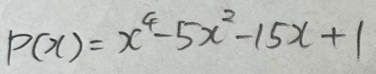

In [ ]:
orig_img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(orig_img)

top_k = 30

for item in scored_sup[:top_k]:
    small_id = item["small"]
    big_id = item["big"]
    score = item["score"]

    small = elements[small_id]
    big = elements[big_id]

    sx, sy, sw, sh = small["bbox"]
    bx, by, bw, bh = big["bbox"]

    # 上付き候補（赤）
    draw.rectangle([(sx, sy), (sx+sw, sy+sh)], outline="red", width=3)

    # 基準文字（青）
    draw.rectangle([(bx, by), (bx+bw, by+bh)], outline="blue", width=3)

    draw.text((sx, sy-10), str(score), fill="yellow")

display(orig_img)


最小部品数(連結成分): 17
候補数(atomic + 再結合候補): 17
  i_like: 0 colon_like: 0 therefore_like: 0
最終トークン数: 17
保存先: /content/final_tokens_overlay.png


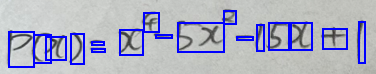

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

# =========================
# 設定（ここだけ要調整）
# =========================
img_path = "/bin/スクリーンショット 2026-02-16 214112.png"  # ←変更

# 「点」とみなす最大サイズ（適宜）
DOT_MAX_W = 10
DOT_MAX_H = 10

# 「棒」とみなす縦長条件（i/jの幹など）
STEM_MIN_H = 12
STEM_MAX_W = 12

# 再結合の近さ（相対値の基準に使う）
# 後で自動化するが、まず固定でOK
NEAR_X = 25
NEAR_Y = 25


# =========================
# 便利関数
# =========================
def bbox_union(bboxes):
    xs = [b[0] for b in bboxes]
    ys = [b[1] for b in bboxes]
    x2 = [b[0] + b[2] for b in bboxes]
    y2 = [b[1] + b[3] for b in bboxes]
    x, y = min(xs), min(ys)
    w, h = max(x2) - x, max(y2) - y
    return [int(x), int(y), int(w), int(h)]

def center_of(bbox):
    x,y,w,h = bbox
    return (x + w/2.0, y + h/2.0)

def dist(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2) ** 0.5

def intersects_or_close(b1, b2, pad=0):
    x1,y1,w1,h1 = b1
    x2,y2,w2,h2 = b2
    # b1をpadだけ膨らませて交差判定
    ax1, ay1 = x1 - pad, y1 - pad
    ax2, ay2 = x1 + w1 + pad, y1 + h1 + pad
    bx1, by1 = x2, y2
    bx2, by2 = x2 + w2, y2 + h2
    return not (ax2 < bx1 or bx2 < ax1 or ay2 < by1 or by2 < ay1)

def sort_by_reading_order(tokens):
    # ざっくり：上→下、左→右
    return sorted(tokens, key=lambda t: (t["bbox"][1], t["bbox"][0]))


# =========================
# 1) 最小部品（連結成分）抽出
# =========================
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"画像が読み込めません: {img_path}")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

bin_img = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

components = []
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    if area < 10:
        continue
    components.append({
        "cid": len(components),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(centroids[i][0]), float(centroids[i][1])],
        "area": int(area),
    })

print("最小部品数(連結成分):", len(components))


# =========================
# 2) 1トークン候補の生成
#    - 初期候補：各連結成分を1トークン候補とする
# =========================
candidates = []
for c in components:
    candidates.append({
        "type": "atomic",          # そのまま
        "parts": [c["cid"]],       # 使った部品ID
        "bbox": c["bbox"],
        "score": 1.0,              # ひとまず同格
    })

# 連結成分の参照用
cid_to_comp = {c["cid"]: c for c in components}


# =========================
# 3) 幾何パターンで再結合候補を生成（意味は使わない）
#    対象：
#      - i/j: 点 + 棒
#      - :  : 2点縦
#      - ∴ : 3点（三角配置）
#    ※ まずはこれだけでOK（爆発を防ぐ）
# =========================
# 分類：点候補・棒候補
dot_ids = []
stem_ids = []

for c in components:
    x,y,w,h = c["bbox"]
    if w <= DOT_MAX_W and h <= DOT_MAX_H:
        dot_ids.append(c["cid"])
    if h >= STEM_MIN_H and w <= STEM_MAX_W:
        stem_ids.append(c["cid"])

dots = [cid_to_comp[i] for i in dot_ids]
stems = [cid_to_comp[i] for i in stem_ids]

# ---- i/j 候補：点が棒の上にある（ほぼ縦に揃う）
ij_candidates = []
for s in stems:
    sx, sy = s["center"]
    sb = s["bbox"]
    for d in dots:
        dx, dy = d["center"]
        db = d["bbox"]

        # 点が棒の上にある＆近い
        if dy < sy and abs(dx - sx) < sb[2]*0.8 and (sy - dy) < sb[3]*1.5:
            # union bbox
            ub = bbox_union([sb, db])
            ij_candidates.append({
                "type": "i_like",
                "parts": [s["cid"], d["cid"]],
                "bbox": ub,
                "score": 3.0,   # atomicより優先させたいので高め
            })

# ---- ":" 候補：2点が縦に並ぶ（xが近く、yが離れすぎない）
colon_candidates = []
dots_sorted = sorted(dots, key=lambda c: c["center"][1])
for i in range(len(dots_sorted)):
    for j in range(i+1, len(dots_sorted)):
        d1 = dots_sorted[i]
        d2 = dots_sorted[j]
        (x1,y1) = d1["center"]
        (x2,y2) = d2["center"]
        if abs(x1-x2) < max(d1["bbox"][2], d2["bbox"][2])*1.2:
            if 5 < (y2-y1) < 40:  # 近すぎ/遠すぎは除外（適宜）
                ub = bbox_union([d1["bbox"], d2["bbox"]])
                colon_candidates.append({
                    "type": "colon_like",
                    "parts": [d1["cid"], d2["cid"]],
                    "bbox": ub,
                    "score": 3.0,
                })

# ---- "∴" 候補：3点が三角配置（上1点＋下2点）
therefore_candidates = []
# ざっくり：上の点1つ、下の点2つで xが左右に分かれ、yが近い
for top in dots:
    tx, ty = top["center"]
    for a in dots:
        for b in dots:
            if len({top["cid"], a["cid"], b["cid"]}) < 3:
                continue
            ax, ay = a["center"]
            bx, by = b["center"]
            # 下2点が同じくらいの高さ
            if abs(ay - by) > 8:
                continue
            # 上が下より上
            if not (ty < ay and ty < by):
                continue
            # 下2点は左右に離れている
            if abs(ax - bx) < 10:
                continue
            # topはその中間にある
            mid = (ax + bx) / 2.0
            if abs(tx - mid) > 12:
                continue
            # 全体サイズが大きすぎない
            ub = bbox_union([top["bbox"], a["bbox"], b["bbox"]])
            if ub[2] > 80 or ub[3] > 80:
                continue
            therefore_candidates.append({
                "type": "therefore_like",
                "parts": [top["cid"], a["cid"], b["cid"]],
                "bbox": ub,
                "score": 4.0,
            })

# 追加
candidates.extend(ij_candidates)
candidates.extend(colon_candidates)
candidates.extend(therefore_candidates)

print("候補数(atomic + 再結合候補):", len(candidates))
print("  i_like:", len(ij_candidates), "colon_like:", len(colon_candidates), "therefore_like:", len(therefore_candidates))


# =========================
# 4) 最終1トークンの確定（重複解決）
#    方針：
#      - 再結合候補を優先（scoreが高い）
#      - 採用済みparts（連結成分）と重複する候補は捨てる
#      - それ以外はatomicを採用
# =========================
candidates_sorted = sorted(candidates, key=lambda c: (-c["score"], c["bbox"][1], c["bbox"][0]))

used_parts = set()
final_tokens = []

for cand in candidates_sorted:
    parts = cand["parts"]
    if any(p in used_parts for p in parts):
        continue
    # 採用
    final_tokens.append(cand)
    for p in parts:
        used_parts.add(p)

# 念のため読み順整列
final_tokens = sort_by_reading_order(final_tokens)

print("最終トークン数:", len(final_tokens))


# =========================
# 5) 可視化：最終トークンだけ四角で囲む
#    - atomic: 青
#    - 再結合: 赤
# =========================
pil = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(pil)

for t in final_tokens:
    x,y,w,h = t["bbox"]
    color = "red" if t["type"] != "atomic" else "blue"
    draw.rectangle([(x,y), (x+w, y+h)], outline=color, width=2)

out_path = "/content/final_tokens_overlay.png"
pil.save(out_path)

print("保存先:", out_path)
display(pil)


最小部品数(連結成分): 17
分割で置き換えた元部品数: 1
分割後の部品数: 18
equals_like候補: 1
最終トークン数: 17
保存先: /content/final_tokens_overlay.png


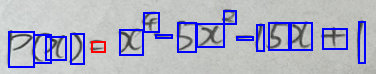

In [4]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

# =========================
# 設定（ここを少し触るだけで調整できる）
# =========================
img_path = "/boot/スクリーンショット 2026-02-16 214112.png"  # ←変更

# 連結成分の最小面積（小さすぎるゴミ除去）
MIN_AREA = 10

# 小さい点（iの点など）判定
DOT_MAX_W = 10
DOT_MAX_H = 10

# 横棒（＝の構成要素）判定
BAR_MIN_RATIO = 3.0     # w/h がこれ以上なら「横棒っぽい」
BAR_MAX_H = 10          # 横棒の高さがこれ以下

# ＝再結合条件（2本の横棒）
EQ_MAX_Y_GAP = 25       # 2本の縦の間隔（ピクセル上限、必要なら調整）
EQ_MIN_X_OVERLAP = 0.6  # x方向の重なり率（0〜1）

# くっつき分割（厳しめに）
SPLIT_MIN_W = 26
SPLIT_MIN_H = 12
SPLIT_MIN_WH_RATIO = 1.20   # ←Pを割りにくくしつつ5xを対象に
MIN_PART_W = 8
MIN_GAP_RATIO = 0.28        # ←谷が浅くても候補にする上限（0〜1）
GAP_RUN = 2                 # ←谷が連続していること（2列）



# =========================
# 便利関数
# =========================
def bbox_union(bboxes):
    xs = [b[0] for b in bboxes]
    ys = [b[1] for b in bboxes]
    x2 = [b[0] + b[2] for b in bboxes]
    y2 = [b[1] + b[3] for b in bboxes]
    x, y = min(xs), min(ys)
    w, h = max(x2) - x, max(y2) - y
    return [int(x), int(y), int(w), int(h)]

def center_of(b):
    x,y,w,h = b
    return (x + w/2.0, y + h/2.0)

def x_overlap_ratio(b1, b2):
    x1, _, w1, _ = b1
    x2, _, w2, _ = b2
    a1, a2 = x1, x1+w1
    b1_, b2_ = x2, x2+w2
    inter = max(0, min(a2, b2_) - max(a1, b1_))
    base = min(w1, w2)
    return inter / base if base > 0 else 0.0

def crop_mask(bin_img, bbox):
    x,y,w,h = bbox
    return bin_img[y:y+h, x:x+w]

def split_component_by_vertical_valley(bin_crop):
    """
    手書きで接触した「5x」等を割るための改良版。
    - 谷が浅くても「局所最小」を複数試す
    - 左右が両方“それなりに太い”ことを要求
    - 横長の塊だけ対象（単文字P等を割りにくく）
    """
    ink = (bin_crop > 0).astype(np.uint8)
    h, w = ink.shape

    if w < SPLIT_MIN_W or h < SPLIT_MIN_H:
        return None
    if (w / max(h, 1)) < SPLIT_MIN_WH_RATIO:
        return None

    proj = ink.sum(axis=0).astype(np.float32)
    if proj.max() == 0:
        return None

    # 平滑化（手書きのギザギザ谷を拾いやすくする）
    k = 5
    proj_s = np.convolve(proj, np.ones(k)/k, mode="same")

    # 正規化（0〜1）
    proj_n = proj_s / proj_s.max()

    # 端で切らない（中央寄り）
    L = int(w * 0.18)
    R = int(w * 0.82)
    if R - L < 12:
        return None

    # 切れ目候補：局所最小 かつ ある程度低い
    cut_candidates = []
    for x in range(L+1, R-1):
        if proj_n[x] <= proj_n[x-1] and proj_n[x] <= proj_n[x+1] and proj_n[x] < MIN_GAP_RATIO:
            cut_candidates.append(x)

    # 候補が無ければ諦め
    if not cut_candidates:
        return None

    # 「谷が連続している」候補を優先（GAP_RUN列）
    def has_run(x):
        a = max(L, x - GAP_RUN + 1)
        b = min(R, x + GAP_RUN)
        return float(proj_n[a:b].max()) < MIN_GAP_RATIO

    # 評価してベストを選ぶ
    best = None
    best_score = -1e9

    for cutx in cut_candidates:
        # run条件は加点（必須にすると割れなくなるので必須にしない）
        run_bonus = 0.15 if has_run(cutx) else 0.0

        left = ink[:, :cutx]
        right = ink[:, cutx:]

        if left.shape[1] < MIN_PART_W or right.shape[1] < MIN_PART_W:
            continue
        if left.sum() < MIN_AREA or right.sum() < MIN_AREA:
            continue

        # 左右の“バランス”が極端だと単文字内部を切った可能性が上がる
        balance = min(left.sum(), right.sum()) / max(left.sum(), right.sum())

        # 谷の深さ（低いほど良い）
        gap_depth = 1.0 - float(proj_n[cutx])

        # 総合スコア：谷の深さ + バランス + runボーナス
        score = gap_depth + 0.8 * balance + run_bonus

        if score > best_score:
            best_score = score
            best = cutx

    if best is None:
        return None

    left = ink[:, :best]
    right = ink[:, best:]

    return (left, right, best)



def bbox_from_mask(mask, offset_x, offset_y):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        return None
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    x = offset_x + x1
    y = offset_y + y1
    w = (x2 - x1 + 1)
    h = (y2 - y1 + 1)
    return [int(x), int(y), int(w), int(h)]

def sort_by_reading_order(tokens):
    return sorted(tokens, key=lambda t: (t["bbox"][1], t["bbox"][0]))

# =========================
# 1) 画像→二値化→連結成分（最小部品）
# =========================
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"画像が読み込めません: {img_path}")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ★注意：ここで「OPEN」を強くやると “5とx” を繋げたり、点を消したりします。
# なので最小限の前処理にします。
bin_img = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 41, 7
)

# 超軽いノイズ除去（やりすぎ注意）
kernel = np.ones((2,2), np.uint8)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img, connectivity=8)

components = []
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    if area < MIN_AREA:
        continue
    components.append({
        "cid": len(components),
        "bbox": [int(x), int(y), int(w), int(h)],
        "center": [float(centroids[i][0]), float(centroids[i][1])],
        "area": int(area),
    })

print("最小部品数(連結成分):", len(components))

# =========================
# 2) くっつき分割（5xなどを2部品に戻す）
#    ※最小部品を「増やす」工程
# =========================
split_added = []
new_components = []

for c in components:
    x,y,w,h = c["bbox"]

    crop = crop_mask(bin_img, c["bbox"])
    res = split_component_by_vertical_valley(crop)

    if res is None:
        new_components.append(c)
        continue

    left_mask, right_mask, cutx = res

    b_left = bbox_from_mask(left_mask, x, y)
    b_right = bbox_from_mask(right_mask, x + cutx, y)

    # 両方取れたら分割採用
    if b_left and b_right:
        split_added.append(c["cid"])
        new_components.append({
            "cid": None,  # 後で振り直す
            "bbox": b_left,
            "center": list(center_of(b_left)),
            "area": int(left_mask.sum())
        })
        new_components.append({
            "cid": None,
            "bbox": b_right,
            "center": list(center_of(b_right)),
            "area": int(right_mask.sum())
        })
    else:
        new_components.append(c)

# cid振り直し
components = []
for i, c in enumerate(new_components):
    c["cid"] = i
    components.append(c)

print("分割で置き換えた元部品数:", len(split_added))
print("分割後の部品数:", len(components))

cid_to_comp = {c["cid"]: c for c in components}

# =========================
# 3) 1トークン候補（初期）：各部品=1トークン候補
# =========================
candidates = []
for c in components:
    candidates.append({
        "type": "atomic",
        "parts": [c["cid"]],
        "bbox": c["bbox"],
        "score": 1.0
    })

# =========================
# 4) 再結合辞書： "=" を追加（横棒2本）
#    ※あなたの言う「辞書」＝ここです
# =========================
# まず横棒候補を集める
bars = []
for c in components:
    x,y,w,h = c["bbox"]
    if h <= BAR_MAX_H and (w / max(h,1)) >= BAR_MIN_RATIO:
        bars.append(c)

eq_candidates = []
# 2本組を探す
bars_sorted = sorted(bars, key=lambda b: b["center"][1])
for i in range(len(bars_sorted)):
    for j in range(i+1, len(bars_sorted)):
        b1 = bars_sorted[i]
        b2 = bars_sorted[j]

        # 縦間隔
        y_gap = abs(b2["center"][1] - b1["center"][1])
        if y_gap > EQ_MAX_Y_GAP:
            break  # これ以上離れるので打ち切り

        # x方向重なり
        ov = x_overlap_ratio(b1["bbox"], b2["bbox"])
        if ov < EQ_MIN_X_OVERLAP:
            continue

        # 高さが近い（太さが近い）
        if abs(b1["bbox"][3] - b2["bbox"][3]) > 4:
            continue

        ub = bbox_union([b1["bbox"], b2["bbox"]])
        eq_candidates.append({
            "type": "equals_like",
            "parts": [b1["cid"], b2["cid"]],
            "bbox": ub,
            "score": 5.0  # 高優先
        })

candidates.extend(eq_candidates)
print("equals_like候補:", len(eq_candidates))

# =========================
# 5) 最終1トークン確定（重複解決）
#    scoreが高い再結合候補を優先し、使ったpartsはatomicから排除
# =========================
candidates_sorted = sorted(candidates, key=lambda c: (-c["score"], c["bbox"][1], c["bbox"][0]))

used_parts = set()
final_tokens = []
for cand in candidates_sorted:
    if any(p in used_parts for p in cand["parts"]):
        continue
    final_tokens.append(cand)
    for p in cand["parts"]:
        used_parts.add(p)

final_tokens = sort_by_reading_order(final_tokens)
print("最終トークン数:", len(final_tokens))

# =========================
# 6) 可視化：最終トークンを囲む
#    - atomic: 青
#    - 再結合(=など): 赤
# =========================
pil = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(pil)

for t in final_tokens:
    x,y,w,h = t["bbox"]
    color = "red" if t["type"] != "atomic" else "blue"
    draw.rectangle([(x,y), (x+w, y+h)], outline=color, width=2)

out_path = "/content/final_tokens_overlay.png"
pil.save(out_path)

print("保存先:", out_path)
display(pil)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')